# SPOTSAR DEMO
## demonstration of SPOTSAR pipeline using CSK spotlight dsc. 2020-09-27 – 2020-11-13 data over Merapi volcano Indonesia.

### 0.0 outline:
- 0.1 Loading dependencies
- 0.2 Loading SPOTSAR
- 1.0 Explain SPOT
- 1.1 Defining testing data
- 1.2 Loading parameters from parameter text file
- 2.0 Adding testing data to multi-kernel data stack
- 2.1 Show workings of Object Oriented Programming (OOP)
- 2.2 Plot 'raw' offset data
- 3.0 Calculate local variablity of query points
- 3.1 Load NDVI map seperately
- 3.2 Show correlation of local variablity with NDVI (vegetation is bad (for X-band))
- 4.0 Explain outlier characteristics with examples
- 4.1 Explain HDBSCAN (and link to resources)
- 4.2 Explain selection on min_cluster_size
- 4.3 Show results from HDBSCAN
- 5.0 Explain multi-kernel averaging (MKA)
- 5.1 Show window size comparison
- 5.2 Show zoomed in regions of interest
- 5.3 Show MKA results
- 6.0 compare single window sizes before HDBSCAN and MKA to MKA results
- 6.1 Calculate local variability for query points


#### 0.1 Loading dependencies
***
Python benefits from an extensive code package library which has code packages
that can significantly aid development efficiency and processing time.

These packages need to be installed to be used and can be loaded in using 'import'.

I strongly reccomend you make an environment for using this code package such that compatibility with the packages can be ensured.

To make an environment please use Anaconda/miniconda and type:

> `conda env create --file SPOTSAR_env.yml`

This will create an environment with the name SPOTSAR that uses python3.8 (version of python in which the SPOTSAR code was developed) This environment will have all the necessary packages with the right version installed.
The command will take some time (several minutes) to compile the right versions of all the packages but it should work and is tested on Mac and Linux. 


Then to activate the environment type:

> `conda activate SPOTSAR`

Sadly some packages have a hard time compiling into the environment, so we add them seperately:

> `conda install -c conda-forge mintpy numba`

Once the environement is activated You can test that it worked by running test_env.py

> `python3 -m test_env`

The environment has been set up correctly if you see the message "imports done".


### 0.2 loading SPOTSAR

we need to not only load the relevant packages but also the code package (SPOTSAR_main) into the notebook

In [ ]:
# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex
import fastparquet # fast read/write for large data structures
import sklearn.preprocessing as pre # for data normalisation
from sklearn.metrics import pairwise_distances

import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm


import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)



from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm



### 1.0 Explain SPOT

The main Sub-Pixel Offset Tracking procedure is done in GAMMA-rs making use of the function 'offset_pwr_tracking2'

The procedure in GAMMA-rs takes to following form:

 1. Make GAMMA SLCs for the SAR data
 2. Select reference SLC and compute map coordinates for each pixel in the ref. SLC using an external DEM.
 3. Co-register the SLCs with the reference SLC, correcting for paralax effects introduced by the topography and non-zero perpendicular baseline. (using rdc_trans) 
 4. Calculate coarse offset map using offset_pwr and window size of 512-by-512
 5. Calculate dense offset maps of increasingly smaller window sizes, each time using the previous offset map as a guide (first time is initialized by the coarse map)
 6. safe results (offsets.txt, ssc_map, offset_map)
 

The image below show the basic workings of pixel offset tracking. 

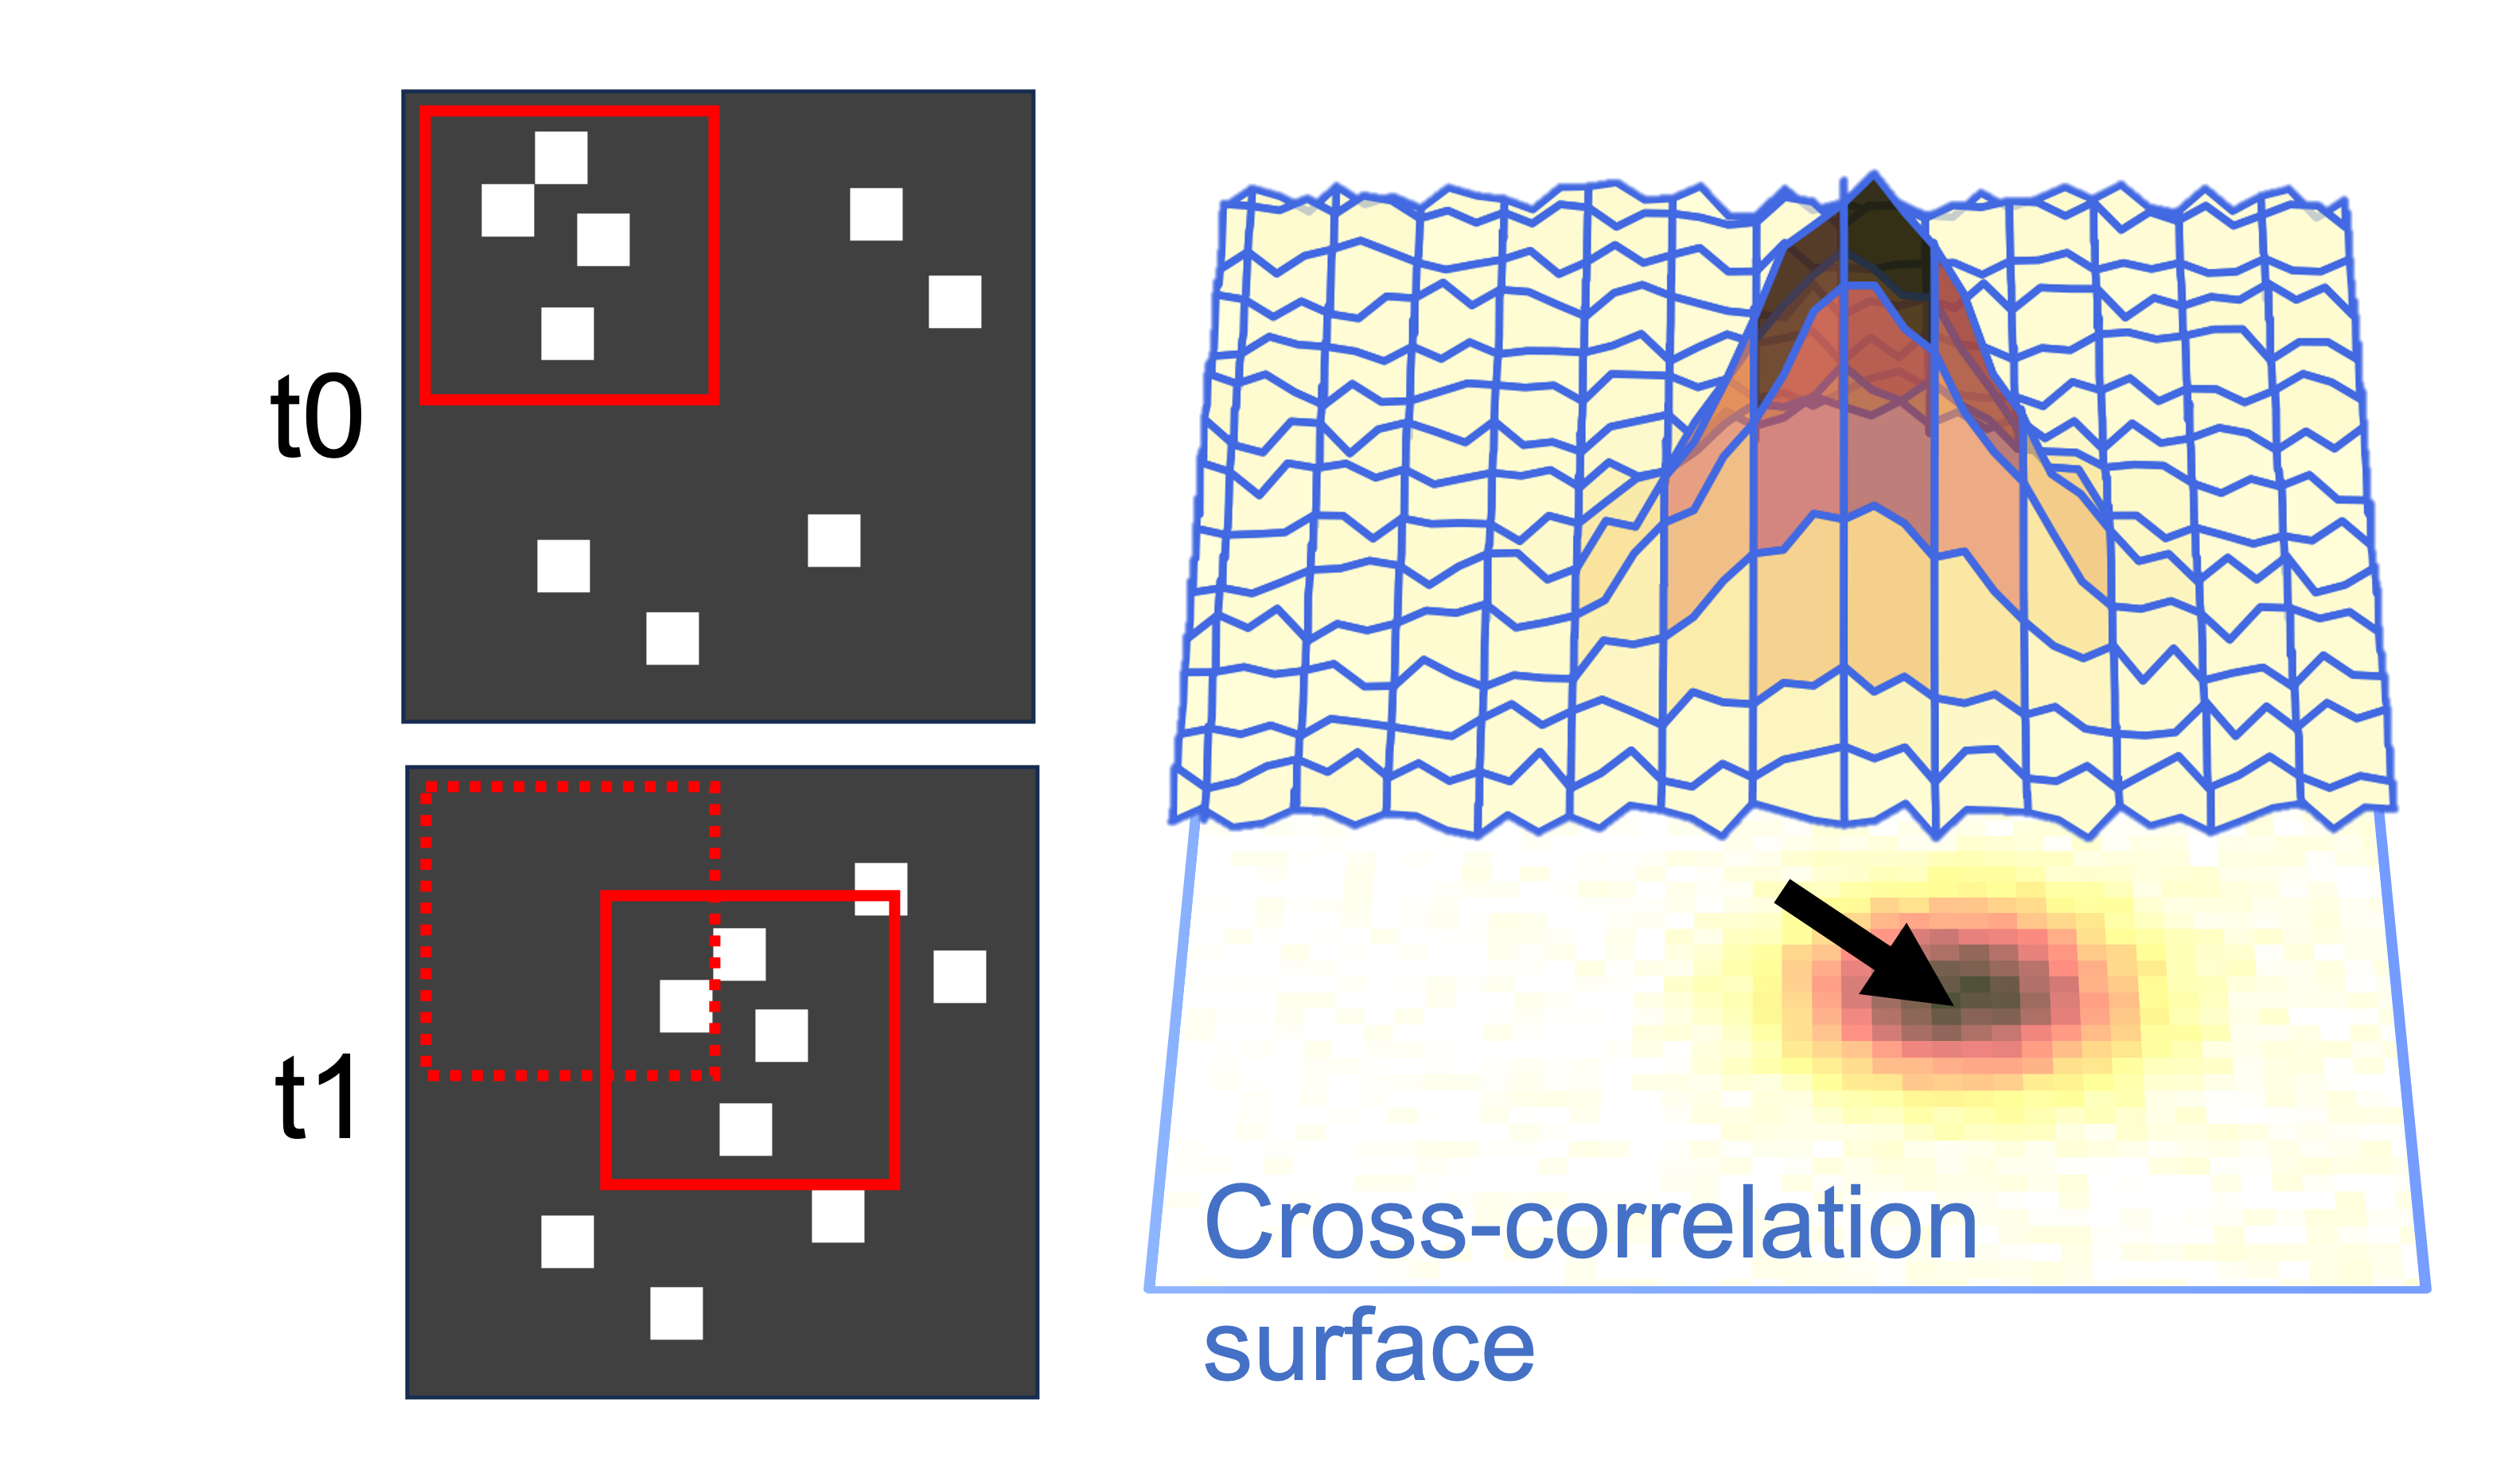



### 1.1 defining our testing data

our test data consists of 3 CSK descending image pairs with varying perpendicular and temporal baseline

- pair 1: 2020-09-27 – 2020-11-13 $B_{perp}$ = 4 m $B_{temp}$ = 47 days
- pair 2: 2020-09-26 – 2020-11-13 $B_{perp}$ = 672 m $B_{temp}$ = 48 days
- pair 3: 2020-09-27 – 2021-08-17 $B_{perp}$ = 1 m $B_{temp}$ = 317 days



In [ ]:
################ Define user INPUTS #######################
######## please edit the values of this block only ########
###########################################################

# define hillshade file
HS_FILE = './test_data/DEM/TDX_Merapi_WGS84_HS.tif'

# define lon and lat files
LON_FILE = './test_data/CSK_dsc/geo/20200910.lon'
LAT_FILE = './test_data/CSK_dsc/geo/20200910.lat'

# define parameter text file
PARAM_FILE = './test_data/CSK_dsc/params.txt'

# define map region of interest
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.535]

# define colour range {min max} (min = -max)
vmax = 3 # range of colourscale in meters

# define file names for data, lon and lat
DIRECTORY_PATH = "./test_data/CSK_dsc/OFFS/"
# define path to ccp and ccs files
DIRECTORY_PATH_CCS = "./test_data/CSK_dsc/CCS/"

# Set the regular expression pattern to match the file names
PATTERN = r"^c[0-9]+_c[0-9]+_disp_[0-9]+_[0-9]+\.txt$"
# Set the regular expression pattern to match the ccs file names
PATTERN_CCS = r"^c[0-9]+_c[0-9]+_ccs_[0-9]+_[0-9]+$"

# open hillshade file and re-order offset and CCS files
# open hill shade file with rasterio
with rio.open(HS_FILE) as src:
    SHADING = src.read(1,masked=True) # rasterio bands are indexed from 1
    
    # extract DEM extent
    DEM_EXTENT=[src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]

# reorder file using Post_processing.reorder_files and regex patterns for the files
matching_files = sm.Post_processing.reorder_files(DIRECTORY_PATH,PATTERN,0)
matching_files_ccs = sm.Post_processing.reorder_files(DIRECTORY_PATH_CCS,PATTERN_CCS,0)

# test if file ordering has worked
print(matching_files)
print(matching_files_ccs)

### loading data into stack

In [ ]:

# load data from files into class multi-kernel
datastack = sm.Post_processing.MultiKernel(DIRECTORY_PATH,
                                           matching_files,
                                           DIRECTORY_PATH_CCS,
                                           matching_files_ccs,
                                           LAT_FILE,
                                           LON_FILE,
                                           HEADING,
                                           MEAN_INC,
                                           LINES_CCS,
                                           WIDTH_CCS)
# We need to assign some data not stored in the disp.txt files.
datastack.get_params_from_file_name()
datastack.get_latlon_from_file(WIDTH)
datastack.add_lat_lon_to_data(R_START,A_START)
datastack.crop_stack_ccs(R_STEP,A_STEP)
# the object datastack now has several attributes associated with the whole dataset (e.g., date1, date2, heading)
# Next we add all the offset data (disp.txt) to the stack
stacked_data = datastack.assign_data_to_stack(R_STEP,A_STEP)
# The attribute 'Stack' we find a list of single-kernel objects which contain the actual offset data, ccp and ccs data and the coordinates.


